<a href="https://colab.research.google.com/github/Dhamodharan2006/Bi-Model-Approach-for-feature-extraction-from-Sensor-data-for-HAV/blob/main/UCI_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
!unzip -q '/content/UCI HAR Dataset.zip'

**Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import  matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve,auc,accuracy_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,TimeDistributed,Conv1D,MaxPooling1D,Dense,Dropout,Flatten,BatchNormalization,Bidirectional,Input,Dense,Activation,LeakyReLU
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dir_path='/content/UCI HAR Dataset'
def read(path):
  return pd.read_csv(path,delim_whitespace=True,header=None)

In [ ]:
signals=['body_acc_x','body_acc_y','body_acc_z','body_gyro_x','body_gyro_y','body_gyro_z','total_acc_x','total_acc_y','total_acc_z']

In [ ]:
def load_d(subset):
  sensor_data=[]
  for sensor in signals:
    file=f'{dir_path}/{subset}/Inertial Signals/{sensor}_{subset}.txt'
    sensor_data.append(read(file).to_numpy())
  return sensor_data

In [ ]:
tr_data=np.array(load_d('train'))
te_data=np.array(load_d('test'))

<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)
<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)
<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)
<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)
<ipython-input-16-66090fe6eb64>:2: FutureWarning

In [ ]:
tr_data=np.transpose(tr_data,(1,2,0))
te_data=np.transpose(te_data,(1,2,0))

In [ ]:
print(tr_data.shape)
print(te_data.shape)

(7352, 128, 9)
(2947, 128, 9)


In [ ]:
def load_y(subset):
    file = f'{dir_path}/{subset}/y_{subset}.txt'
    y = read(file)
    return y

In [ ]:
y_train=np.array(load_y('train'))
y_test=np.array(load_y('test'))

<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)
<ipython-input-16-66090fe6eb64>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path,delim_whitespace=True,header=None)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(7352, 1)
(2947, 1)


In [ ]:
y_train=y_train-1
y_test=y_test-1

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0.])

In [ ]:
ts = len(x_train[0])
inp_dim = len(x_train[0][0])

print(ts)
print(inp_dim)
print(len(x_train))

128
9
7352


In [ ]:
steps,length=4,32
x_train=x_train.reshape((x_train.shape[0],steps,length,inp_dim))
x_test=x_test.reshape((x_test.shape[0],steps,length,inp_dim))

In [ ]:
x_train.shape

(7352, 4, 32, 9)

**Using 1D CNN + LSTM**


In [ ]:
model=Sequential()
model.add(TimeDistributed(Conv1D(128,kernel_size=3,kernel_regularizer=l2(0.01)),input_shape=(None,length,inp_dim)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(TimeDistributed(Conv1D(64,kernel_size=3,kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(TimeDistributed(MaxPooling1D(pool_size=4)))
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 30, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 30, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, None, 30, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 30, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 28, 64)        │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 28, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, None, 28, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 28, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 448)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 128)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 335,142 (1.28 MB)

 Trainable params: 334,758 (1.28 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
his=model.fit(x_train,y_train,batch_size=64,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.4711 - loss: 2.4357 - val_accuracy: 0.2769 - val_loss: 4.7216
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7110 - loss: 1.1905 - val_accuracy: 0.2732 - val_loss: 4.8637
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8670 - loss: 0.7234 - val_accuracy: 0.4086 - val_loss: 3.7367
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9050 - loss: 0.5347 - val_accuracy: 0.6932 - val_loss: 1.4996
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9134 - loss: 0.4755 - val_accuracy: 0.8772 - val_loss: 0.5162
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9062 - loss: 0.4413 - val_accuracy: 0.9077 - val_loss: 0.4052
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9220 - loss: 0.3976 - val_accuracy: 0.8870 - val_loss: 0.4840
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9253 - loss: 0.3898 - val_acc

In [ ]:
y_pred=model.predict(x_test)
y_p=np.argmax(y_pred,axis=1)
y_t=np.argmax(y_test,axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


<ipython-input-46-8955be92f632>:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


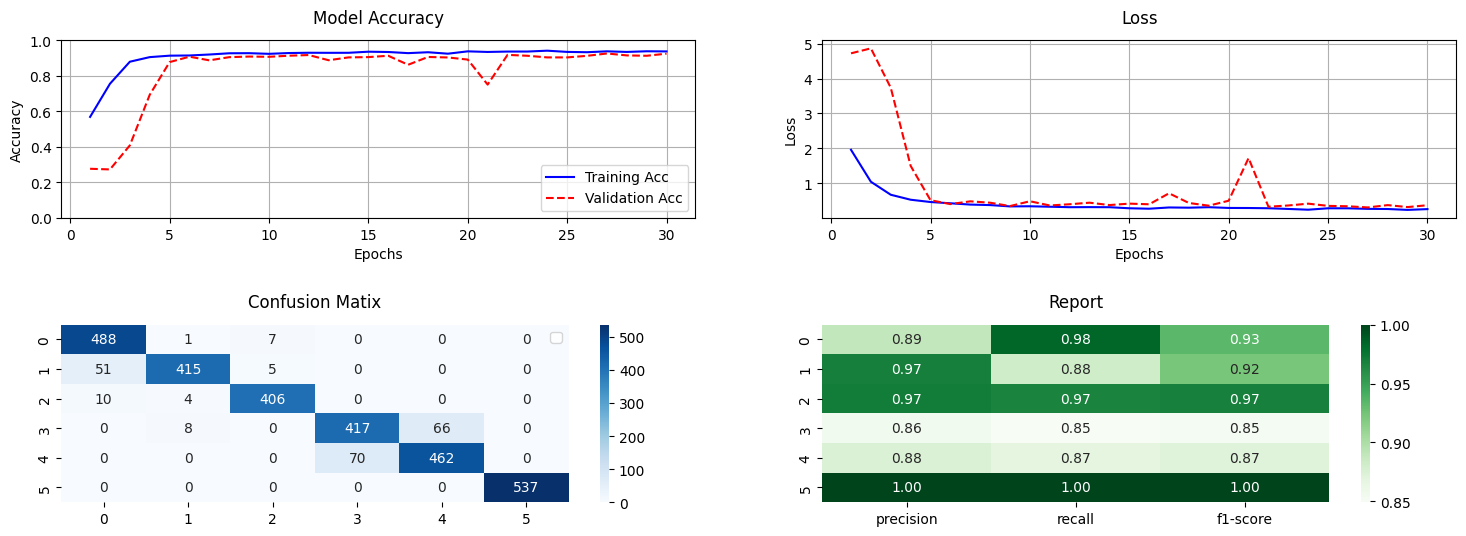

In [ ]:
epcs = range(1, len(his.history['accuracy']) + 1)
f,ax=plt.subplots(2,2,figsize=(18,6))

ax[0,0].plot(epcs,his.history['accuracy'],'b-',label="Training Acc")
ax[0,0].plot(epcs,his.history['val_accuracy'],'r--',label="Validation Acc")

ax[0,0].set_title("Model Accuracy",fontsize=12, y=1.05)
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Accuracy")
ax[0,0].set_ylim(0,1)
ax[0,0].grid(True)
ax[0,0].legend()

ax[0,1].plot(epcs,his.history['loss'],'b-',label="Training Acc")
ax[0,1].plot(epcs,his.history['val_loss'],'r--',label="Validation Acc")

ax[0,1].set_title("Loss",y=1.05)
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].grid(True)

cm=confusion_matrix(y_t,y_p)
sns.heatmap(cm,annot=True,ax=ax[1,0],fmt='d', cmap='Blues')
ax[1,0].set_title("Confusion Matix", y=1.05)
ax[1,0].legend()
ax[0,1].grid(True)

rp=classification_report(y_t,y_p,output_dict=True)
cr=pd.DataFrame(rp).T
sns.heatmap(cr.iloc[:-3,:-1],annot=True,fmt='.2f',ax=ax[1,1],cmap='Greens')
ax[1,1].set_title("Report", y=1.05)
ax[0,1].grid(True)
plt.subplots_adjust(hspace=0.6,wspace=0.2)

**Feature Extraction with Tsfel**

In [ ]:
import tsfel as ts

In [ ]:
X=tr_data
num=X.shape[0]

In [ ]:
tr_data.shape

(7352, 128, 9)

In [ ]:
cond=ts.get_features_by_domain('all')

In [ ]:
def ext_feat(sample):
    sample_df = pd.DataFrame(sample, columns=signals)
    feat = ts.time_series_features_extractor(cond, sample_df, fs=50, verbose=0)
    return feat

In [ ]:
from joblib import Parallel, delayed
features_list = Parallel(n_jobs=-1)(
    delayed(ext_feat)(X[i])
    for i in tqdm(range(num), desc="Extracting features")
)
features_df = pd.concat(features_list, ignore_index=True)

Extracting features: 100%|██████████| 7352/7352 [11:28<00:00, 10.68it/s]


In [ ]:
from joblib import Parallel, delayed
test_features_list = Parallel(n_jobs=-1)(
    delayed(ext_feat)(te_data[i])
    for i in tqdm(range(te_data.shape[0]), desc="Extracting features")
)
test_features_df = pd.concat(test_features_list, ignore_index=True)

Extracting features: 100%|██████████| 2947/2947 [04:32<00:00, 10.83it/s]


In [ ]:
train_df = features_df.dropna(axis=1, how="all")

In [ ]:
test_df=test_features_df.dropna(axis=1,how='all')

In [ ]:
print("NaN counts:", train_df.isna().sum().sum())
print("NaN counts:", test_df.isna().sum().sum())

NaN counts: 0
NaN counts: 0


In [ ]:
sc=StandardScaler()
train_df=sc.fit_transform(train_df)
test_df=sc.fit_transform(test_df)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(7352, 1413)
(2947, 1413)


**Defining AutoEncoder Architecture for Capturing Important Features from Extracted Data**

In [ ]:
a_enc=Sequential()
a_enc.add(Dense(512,input_shape=(train_df.shape[1],)))
a_enc.add(BatchNormalization())
a_enc.add(LeakyReLU(alpha=0.1))
a_enc.add(Dropout(0.4))
a_enc.add(Dense(256))
a_enc.add(BatchNormalization())
a_enc.add(LeakyReLU(alpha=0.1))
a_enc.add(Dropout(0.3))
a_enc.add(Dense(128,activation='linear'))

a_enc.add(Dense(128))
a_enc.add(BatchNormalization())
a_enc.add(LeakyReLU(alpha=0.1))
a_enc.add(Dropout(0.3))
a_enc.add(Dense(256))
a_enc.add(BatchNormalization())
a_enc.add(LeakyReLU(alpha=0.1))
a_enc.add(Dropout(0.3))
a_enc.add(Dense(train_df.shape[1],activation='sigmoid'))
opt=Adam(0.001)
a_enc.compile(optimizer=opt,loss='mse',metrics=['mae'])

a_enc.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 512)                 │         723,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1413)                │         363,141 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,305,477 (4.98 MB)

 Trainable params: 1,303,173 (4.97 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
early_stp=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
a_enc.fit(train_df,train_df,epochs=100,batch_size=64,shuffle=True,validation_data=(test_df,test_df),callbacks=[early_stp])

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6306 - mae: 0.5460 - val_loss: 0.6351 - val_mae: 0.5615
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6285 - mae: 0.5449 - val_loss: 0.6346 - val_mae: 0.5606
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6109 - mae: 0.5427 - val_loss: 0.6344 - val_mae: 0.5613
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6381 - mae: 0.5479 - val_loss: 0.6347 - val_mae: 0.5605
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6327 - mae: 0.5464 - val_loss: 0.6339 - val_mae: 0.5601
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6395 - mae: 0.5464 - val_loss: 0.6344 - val_mae: 0.5617
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6335 - mae: 0.5457 - val_loss: 0.6339 - val_mae: 0.5605
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6312 - mae: 0.5446 - val_loss: 0.6341 - val_mae: 0.5611
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/

In [ ]:
enc=Model(a_enc.inputs,a_enc.layers[11].output)

In [ ]:
X_train=encoder.predict(train_df)
X_test=encoder.predict(test_df)

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
X_train.shape
X_test.shape

(2947, 64)

**Training RandomForest,SVM & LogisticRegression on Extracted data**

In [ ]:
rf=RandomForestClassifier(n_estimators=300,criterion='entropy',bootstrap=True)
rf.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', n_estimators=300)

In [ ]:
from sklearn.svm import SVC
svm=SVC(kernel='rbf')
svm.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty='l2')
lr.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
def plot(models,x_train,x_test):
  f,ax=plt.subplots(3,2,figsize=(20,10))
  for i,(name,model)in enumerate(models.items()):
    y_pred=model.predict(x_test)
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,fmt='d',annot=True,cmap='Blues',ax=ax[i,0])
    ax[i,0].set_title(f"Confusion Matix for {name}")
    rp=classification_report(y_pred,y_test,output_dict=True)
    cr=pd.DataFrame(rp).T
    sns.heatmap(cr.iloc[:-3,:-1],annot=True,cmap='Greens',ax=ax[i,1])
    ax[i,1].set_title(f"Report for {name}")
    tr_acc=accuracy_score(y_train,model.predict(x_train))*100
    te_acc=accuracy_score(y_test,y_pred)*100
    ax[i,1].text(
            0.5, -0.4, f"Train Accuracy: {tr_acc:.2f}  |  Test Accuracy: {te_acc:.2f}",
            ha="center", va="top", fontsize=12, transform=ax[i, 1].transAxes
        )
  plt.subplots_adjust(hspace=1,wspace=0.2)

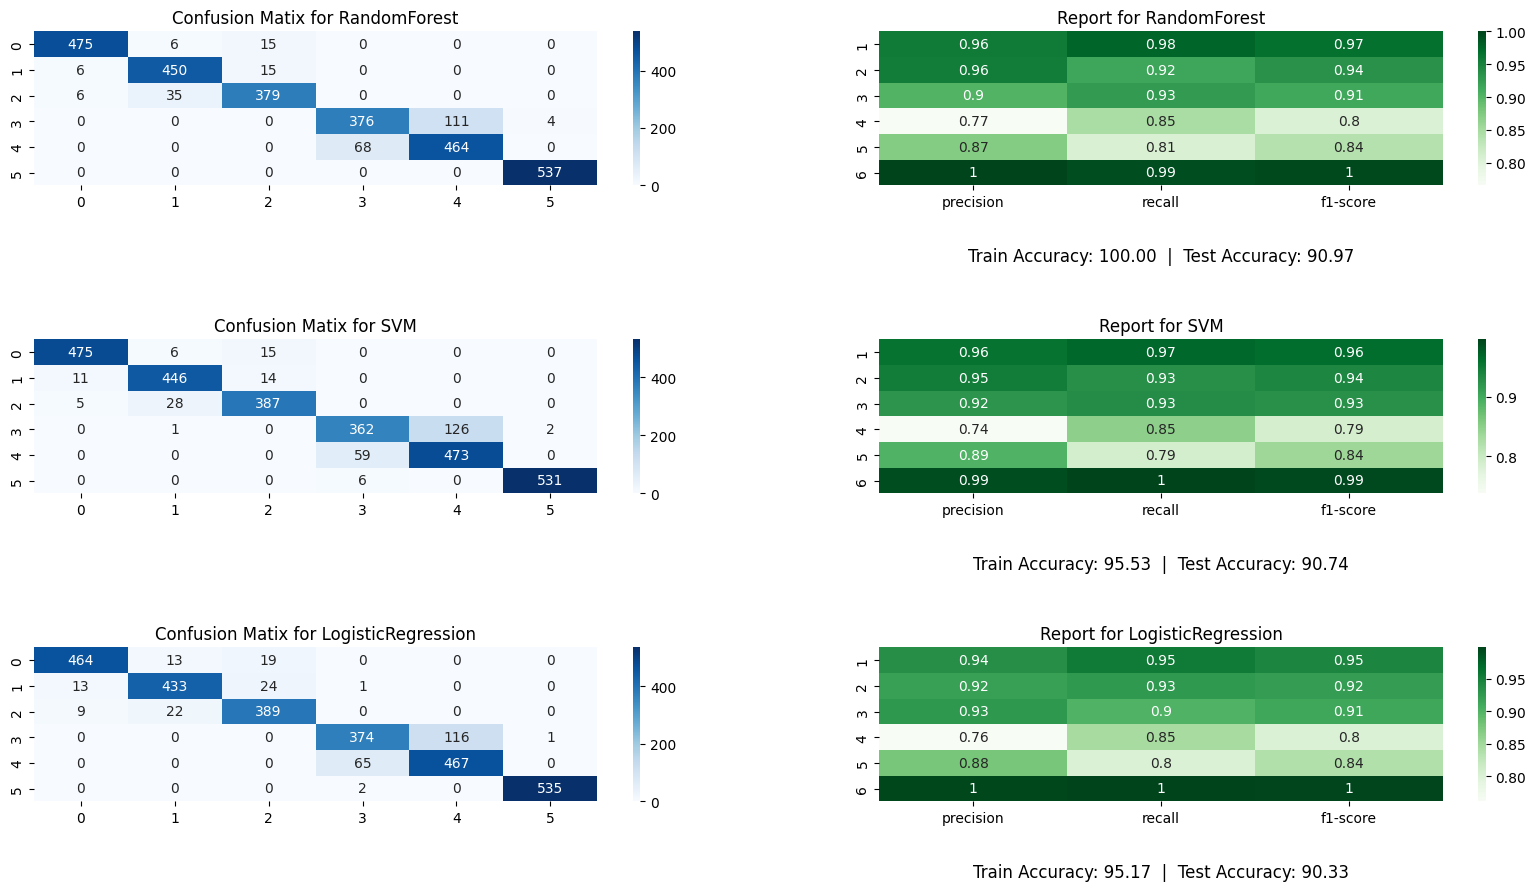

In [ ]:
models={'RandomForest':rf,'SVM':svm,"LogisticRegression":lr}
plot(models,X_train,X_test)

**Training using Author's Extracted features data**

In [ ]:
X_tr=np.loadtxt('/content/UCI HAR Dataset/train/X_train.txt')
Y_tr=np.loadtxt('/content/UCI HAR Dataset/train/y_train.txt')
X_te=np.loadtxt('/content/UCI HAR Dataset/test/X_test.txt')
Y_te=np.loadtxt('/content/UCI HAR Dataset/test/y_test.txt')

In [ ]:
print(X_tr.shape)
print(X_te.shape)

(7352, 561)
(2947, 561)


In [ ]:
X_tr=sc.fit_transform(X_tr)
X_te=sc.fit_transform(X_te)

In [ ]:
rf2=RandomForestClassifier(n_estimators=300,criterion='entropy')
rf2.fit(X_tr,Y_tr)

RandomForestClassifier(criterion='entropy', n_estimators=300)

In [ ]:
svm2=SVC(kernel='rbf')
svm2.fit(X_tr,Y_tr)

SVC()

In [ ]:
lr2=LogisticRegression(penalty='l2')
lr2.fit(X_tr,Y_tr)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

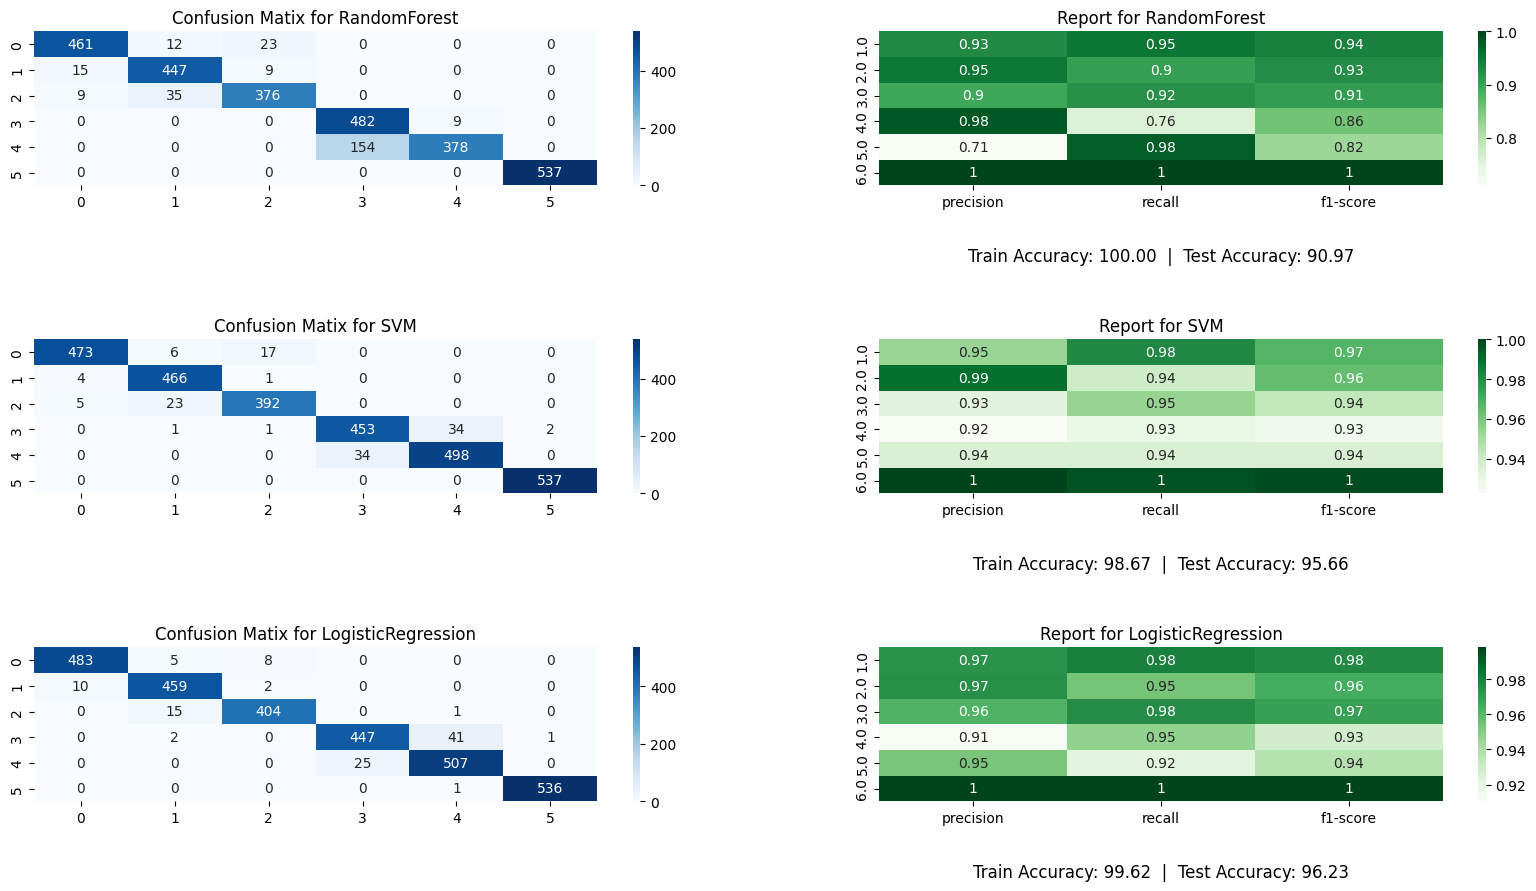

In [ ]:
models={'RandomForest':rf2,'SVM':svm2,"LogisticRegression":lr2}
plot(models,X_tr,X_te)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_comparison(models, train_raw, test_raw, train_tsfel, test_tsfel):
    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5*width, train_raw, width, label="Train (Author's)", color='royalblue')
    ax.bar(x - 0.5*width, test_raw, width, label="Test (Autor's)", color='deepskyblue')
    ax.bar(x + 0.5*width, train_tsfel, width, label="Train (Manual)", color='mediumseagreen')
    ax.bar(x + 1.5*width, test_tsfel, width, label="Test (Manual)", color='lightgreen')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.set_title("Model Accuracy Comparison: Author Features vs Manually Extracted")
    ax.grid(axis='y', linestyle="--", alpha=0.7)
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

    plt.tight_layout()
    plt.show()


In [ ]:
train_man=[100.0,95.53,95.17]
test_man=[90.97,90.74,90.33]
train_aut=[100.0,98.67,99.62]
test_aut=[90.97,95.66,96.23]

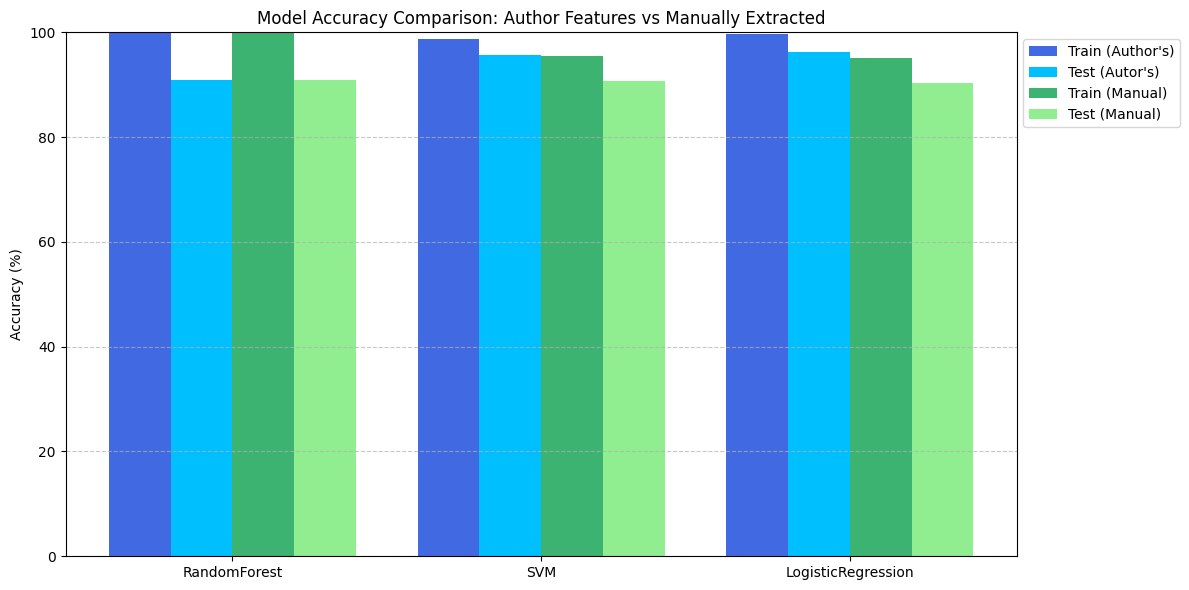

In [ ]:
plot_accuracy_comparison(models,train_aut,test_aut,train_man,test_man)